# Data cleaning pipeline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import timedelta
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

## `admissions` table

In [3]:
admissions = pd.read_csv("admissions.csv", parse_dates=["admittime", "dischtime"])

# admissions = pdread_csv("//original_data/admissionscsv")

# drop all admission events where people die
admissions = admissions[admissions['hospital_expire_flag'] == 0]

# drop deathtime and hospital_expire_flag as we now don't have any patients that die
# drop provider id as that's not something that's generalisable to other systems/datasets
admissions = admissions.drop(columns=["deathtime", "hospital_expire_flag", "admit_provider_id"])

# Sort by subject_id and admittime to ensure proper sequencing
admissions = admissions.sort_values(by=["subject_id", "admittime"])

# Compute time until net admission for each subject_id
admissions["time_until_next_admission"] = admissions.groupby("subject_id")["admittime"].shift(-1) - admissions["dischtime"]

# Convert the result to days
admissions["time_until_next_admission"] = admissions["time_until_next_admission"].dt.total_seconds() / (24 * 3600)

admissions["time_until_next_admission"] = admissions["time_until_next_admission"].round(0).astype("Int64")  # Keeps NaN as is

# admissions["time_until_next_admission"] = admissions["time_until_next_admission"].apply(lambda x: "180+" if x > 180 else x)


# compute length of stay
admissions["length_of_stay"] = admissions["dischtime"]- admissions["admittime"]

# Convert the result to days
admissions["length_of_stay"] = admissions["length_of_stay"].dt.total_seconds() / (24 * 3600)

admissions["length_of_stay"] = admissions["length_of_stay"].round(0).astype("Int64")  # Keeps NaN as is

# admissions["time_until_net_admission"] = admissions["time_until_net_admission"]apply(lambda : "180+" if  > 180 else )

# bins = list(range(0, 95, 1)) + [180, npinf]  # 0-5, 5-10, , 85-90, 90-180, >180
# labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-2)] + ["180+"]

# # Create a new column with categorized time until net admission
# admissions["time_until_net_admission_bucket"] = pdcut(admissions["time_until_net_admission"], bins=bins, labels=labels, right=False)

# Display the first few rows
admissions.set_index(["hadm_id"], inplace=True)


In [15]:
admissions.columns

Index(['subject_id', 'admittime', 'dischtime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'race', 'edregtime', 'edouttime',
       'time_until_next_admission', 'length_of_stay'],
      dtype='object')

In [17]:
temp_df = admissions.drop(columns = ['subject_id', 'admittime', 'dischtime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'race', 'edregtime', 'edouttime',
       'length_of_stay'])

temp_df.to_csv("readmission_corrected.csv")

In [49]:
# time_data = admissions["time_until_net_admission"].dropna()

# # Plot the distribution
# plt.figure(figsize=(10, 6))
# sns.boxplot(time_data)

# # Labels and title
# plt.label("Days Until Net Admission")
# plt.ylabel("Frequency")
# plt.title("Distribution of Time Until Net Admission")
# plt.grid(True)

# # Show the plot
# plt.show()


## diagnostic data

In [4]:
diagnoses_icd = pd.read_csv("diagnoses_icd.csv").drop("subject_id", axis=1) # remove subject id so that it doesn't overlap with the admissions 

d_icd_diagnoses = pd.read_csv("d_icd_diagnoses.csv", index_col="icd_code")

diagnoses = diagnoses_icd.merge(d_icd_diagnoses, how='left', on=["icd_code", "icd_version"])

diagnoses['diagnoses_icd'] =  diagnoses['icd_version'].astype(str) + '_' + diagnoses['icd_code'].astype(str)

diagnoses = diagnoses.drop(['icd_version', 'icd_code'], axis=1)

diagnoses = diagnoses.rename(columns={"seq_num": "diagnoses_seq_num", "long_title": "diagnoses_long_title"})

diagnoses = diagnoses.groupby('hadm_id').agg(lambda x: x.tolist())

## procedures data

In [5]:
procedures_icd = pd.read_csv("procedures_icd.csv").drop("subject_id", axis=1)

d_icd_procedures = pd.read_csv("d_icd_procedures.csv")

procedures = procedures_icd.merge(d_icd_procedures, how='left', on=["icd_code", "icd_version"])

procedures['procedures_icd'] =  procedures['icd_version'].astype(str) + '_' + procedures['icd_code'].astype(str)

procedures = procedures.drop(['icd_version', 'icd_code'], axis=1)

procedures = procedures.rename(columns={"seq_num": "procedures_seq_num", "long_title": "procedures_long_title"})

procedures = procedures.groupby('hadm_id').agg(lambda x: x.tolist())

## microbiology

In [52]:
microbiology = pd.read_csv("../../original_data/microbiologyevents.csv")

microbiology = microbiology.drop(["subject_id", "order_provider_id"], axis=1)

microbiology = microbiology.dropna(subset=['hadm_id'])

/var/folders/9v/_3psvbl52k53mrrcnt2q29rr0000gq/T/ipykernel_16495/560190241.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  microbiology = pd.read_csv("../../original_data/microbiologyevents.csv")


## discharge master

## merge eleganaza 

In [7]:
master_df = pd.concat(objs=[admissions, diagnoses, procedures], axis=1, join="inner")

master_df.to_csv("master_df.csv")

In [ ]:
# discharge_master = pd.read_csv("discharge_master.csv")

# discharge_columns = set(discharge_master.columns)
# master_columns = set(master_df.columns)

# intersection = list(discharge_columns.intersection(master_columns))

discharge_master = discharge_master.drop(columns=intersection)

master_df = master_df.merge(discharge_master, how="left", on="hadm_id")

master_df.to_csv("new_discharge_master.csv")

master_df.head()

In [18]:
master_df.columns

Index(['hadm_id', 'subject_id', 'admittime', 'dischtime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'race', 'edregtime', 'edouttime',
       'time_until_next_admission', 'length_of_stay', 'diagnoses_seq_num',
       'diagnoses_long_title', 'diagnoses_icd', 'procedures_seq_num',
       'chartdate', 'procedures_long_title', 'procedures_icd', 'note_id',
       'note_type', 'note_seq', 'charttime', 'storetime', 'text', 'gender',
       'anchor_age', 'anchor_year', 'anchor_year_group', 'dod'],
      dtype='object')

In [2]:
temp_df = pd.read_csv("new_discharge_master.csv")

temp_df.columns

Index(['Unnamed: 0', 'hadm_id', 'subject_id_x', 'admittime_x', 'dischtime_x',
       'admission_type_x', 'admission_location_x', 'discharge_location_x',
       'insurance_x', 'language_x', 'marital_status_x', 'race_x',
       'edregtime_x', 'edouttime_x', 'time_until_next_admission_x',
       'length_of_stay', 'diagnoses_seq_num_x', 'diagnoses_long_title_x',
       'diagnoses_icd_x', 'procedures_seq_num_x', 'chartdate_x',
       'procedures_long_title_x', 'procedures_icd_x', 'subject_id_y',
       'admittime_y', 'dischtime_y', 'admission_type_y',
       'admission_location_y', 'discharge_location_y', 'insurance_y',
       'language_y', 'marital_status_y', 'race_y', 'edregtime_y',
       'edouttime_y', 'time_until_next_admission_y', 'diagnoses_seq_num_y',
       'diagnoses_long_title_y', 'diagnoses_icd_y', 'procedures_seq_num_y',
       'chartdate_y', 'procedures_long_title_y', 'procedures_icd_y', 'note_id',
       'note_type', 'note_seq', 'charttime', 'storetime', 'text', 'gender',
   

# LACE INDEX??

### pre-processing functions

In [11]:
def is_substring(substrings, target):
    return any(substring in target for substring in substrings)

def calculate_l(los):
    if los == 1:
        return 1
    elif los == 2:
        return 2
    elif los == 3:
        return 3
    elif 4 <= los <= 6:
        return 4
    elif 7 <= los <= 13:
        return 5
    elif los >= 14:
        return 7
    else:
        return 0 # Means LoS

def calculate_a(admission_location : str):
    if type(admission_location) is float:
        return 0
    elif admission_location.upper() == "EMERGENCY ROOM":
        return 3
    
    return 0
    
def calculate_c(diagnoses_icd):
    c = 0

    myocardial_infarction_9 = ["410", "412"]
    myocardial_infarction_10 = ["I21", "I22", "I252"]
    myocardial_reported = False

    congestive_heart_failure_9 = ["428", "39891", "40201", "40211", "40291", "40401", "40403", "40411", "40413", "40491", "40493"]
    congestive_heart_failure_10 = ["I110", "I130", "I132", "I255", "I420", "I425", "I426", "I427", "I428", "I429", "I43", "I50", "P290"]
    heart_failure_reported = False

    peripheral_vascular_disease_9 = ["4439", "444", "7854", "V434*", "Proc", "3848", "0930", "4373", "440", "441", "4431", "4432", "4438",
                                     "4439", "4471", "5571", "5579", "V434*"]
    peripheral_vascular_disease_10 = ["I70", "I71", "I731", "I738", "I739", "I771", "I790", "I791", "I798", "K551", "K558", "K559", "Z958", "Z959"]
    vascular_disease = False

    cerebrovascular_disease_9 = ["430", "431", "432", "433", "434", "435", "436", "437", "438", "36234"]
    cerebrovascular_disease_10 = ["G45", "G46", "H340", "H341", "H342", "I60", "I61", "I62", "I63", "I64", "I65", "I66", "I67", "I68"]
    cerebrovascular_reported = False

    dementia_9 = ["290", "2900", "2901", "2902", "2903", "2904", "2940", "2941", "2942", "2948", "3310", "3311", "3312", "3317", "797"]
    dementia_10 = ["F01", "F02", "F03", "F04", "F05", "F061", "F068", "G132", "G138", "G30", "G310", "G311", "G312", "G914", "G94", "R4181", "R54"]
    dementia_reported = False

    chronic_pulmonary_disease_9 = ["490", "491", "492", "493", "494", "495", "496", "500", "501", "502", "503", "504", "505", "5064",
                                   "5081", "5088"]
    chronic_pulmonary_disease_10 = ["J40", "J41", "J42", "J43", "J44", "J45", "J46", "J47", "J60", "J61", "J62", "J63", "J64",
                                    "J65", "J66", "J67", "J684", "J701", "J703"]
    pulmonary_reported = False

    rheumatic_disease_9 = ["7100", "7101", "7104", "7140", "7141", "7142", "71481", "725", 
                           "4465", "7103", "7140", "7141", "7142", "7148"]
    rheumatic_disease_10 = ["M05", "M06", "M315", "M32", "M33", "M34", "M351", "M353", "M360"]
    rheumatic_reported = False

    peptic_ulcer_disease_9 = ["531", "532", "533", "534"]
    peptic_ulcer_disease_10 = ["K25", "K26", "K27", "K28"]
    ulcer_reported = False

    mild_liver_disease_9 = ["5712", "5714", "5715", "5716", "07022", "07023", "07032", "07033", "07044", "07054", "0706", "0709", 
                            "570", "571", "5733", "5734", "5738", "5739", "V427*"]
    mild_liver_disease_10 = ["B18", "K700", "K701", "K702", "K703", "K709", "K713", "K714", "K715", "K717", "K73", "K74", "K760", 
                             "K762", "K763", "K764", "K768", "K769", "Z944"]
    liver_reported = False

    diabetes_not_chronic_9 = ["2500", "2501", "2502", "2503", "2507", "2508", "2509", "2490", "2491", "2492", "2493", "2499"]
    diabetes_not_chronic_10 = ['E080', 'E081', 'E086', 'E088', 'E089', 'E090', 'E091', 'E096', 'E098', 'E099', 'E100', 'E101', 'E106', 'E108', 'E109', 
                   'E110', 'E111', 'E116', 'E118', 'E119', 'E130', 'E131', 'E136', 'E138', 'E139']
    diabetes_not_chronic = False

    mild_renal_9 = ["40300", "40310", "40390", "40400", "40401", "40410", "40411", "40490", "40491", "582", "583", "5851", "5852", 
               "5853", "5854", "5859", "V420"]
    mild_renal_10 = ["I129", "I130", "I1310", "N03", "N05", "N181", "N182", "N183", "N184", "N189", "Z940"]
    mild_renal = False

    diabetes_chronic_9 = ["2504", "2506", "2505", "2507"]
    diabetes_chronic_10 = ['E082', 'E083', 'E084', 'E085', 'E092', 'E093', 'E094', 'E095', 'E102', 'E103', 'E104', 'E105', 'E112', 
                           'E113', 'E114', 'E115', 'E132', 'E133', 'E134', 'E135']
    diabetes_chronic = False

    hemiplegia_paraplegia_9 = ["3341", "342", "343", "344"]
    hemiplegia_paraplegia_10 = ["G041", "G114", "G800", "G801", "G802", "G81", "G82", "G83"]
    hemiplegia_paraplegia = False

    malignancy_9 = ["14", "15", "16", "170", "171", "172", "174", "175", "176", "179", "18", "190", "191", "192", "193",
                    "194", "195", "1991", "200", "201", "202"]
    malignancy_10 = ["C0", "C1", "C2", "C30", "C31", "C32", "C33", "C34", "C37", "C38", "C39", "C40", "C41", "C43", 
                     "C45", "C46", "C47", "C48", "C49", "C50", "C51", "C52", "C53", "C54", "C55", "C56", "C57", "C58",
                     "C60", "C61", "C62" "C63", "C76", "C801", "C81", "C82", "C83",
                     "C84", "C85", "C88"]
    malignancy = False

    severe_liver_9 = ["4560", "4561", "4562", "5722", "5723", "5724", "5728"]
    severe_liver_10 = ["I850", "I864", "K704", "K711", "K729", "K765", "K766", "K767"]
    severe_liver = False

    severe_renal_9 = ["40301", "40311", "40391", "40402", "40403", "40412", "40413", "40492", "40493", "5855", "5856", "586", "5880",
                      "V4511", "V4512", "V560", "V561", "V562", "V5631", "V5632", "V568"]
    severe_renal_10 = ["I120", "I1311", "I132", "N185", "N186", "N19", "N250", "Z49", "Z992"]
    severe_renal = False

    hiv_9 = ["042"]
    hiv_10 = ["B20"]
    hiv = False

    tumour_9 = ["196", "197", "198", "1990"]
    tumour_10 = ["C77", "C78", "C79", "C800", "C802"]
    tumour = False

    aids_9 = ["112", "180", "114", "1175", "0074", "0785", "3483", "054", "115", "0072", "176", "200", "201", "202", "203", "204", "205",
              "206", "207", "208", "209", "031", "010", "011", "012", "013", "014", "015", "016", "017", "018", "1363", "V1261", "0463", "0031",
              "130", "7994"]
    aids_10 = ["B37", "C53", "B38", "B45", "A072", "B25", "G934", "B00", "B39", "A073", "C46", "C81", "C82", "C83", "C84", "C85", "C86", 
               "C87", "C88", "C89", "C90", "C91", "C92", "C93", "C94", "C95", "C96", "A31", "A15", "A16", "A17", "A18", "A19", "B59", "Z8701", "A812",
               "A021", "B58", "R64"]
    aids = False

    # note: each thing is formatted as icdVersion_icdCode
    for diagnose in diagnoses_icd:
        diagnose = diagnose.split("_")
        icd_version = diagnose[0]
        icd_code = diagnose[1]

        if str(icd_version) == "9":
            if is_substring(icd_code, myocardial_infarction_9) and not myocardial_reported:
                c += 1
                myocardial_reported = True

            elif is_substring(icd_code, congestive_heart_failure_9) and not heart_failure_reported:
                c += 1 
                heart_failure_reported = True

            elif is_substring(icd_code, peripheral_vascular_disease_9) and not vascular_disease:
                c += 1
                vascular_disease = True

            elif is_substring(icd_code, cerebrovascular_disease_9) and not cerebrovascular_reported:
                c += 1
                cerebrovascular_reported = True
            
            elif is_substring(icd_code, dementia_9) and not dementia_reported:
                c += 1
                dementia_reported = True
            
            elif is_substring(icd_code, chronic_pulmonary_disease_9) and not pulmonary_reported:
                c += 1
                pulmonary_reported = True

            elif is_substring(icd_code, rheumatic_disease_9) and not rheumatic_reported:
                c += 1
                rheumatic_reported = True

            elif is_substring(icd_code, peptic_ulcer_disease_9) and not ulcer_reported:
                c += 1
                ulcer_reported = True

            elif is_substring(icd_code, mild_liver_disease_9) and not liver_reported:
                c +=1 
                liver_reported = True

            elif is_substring(icd_code, diabetes_not_chronic_9) and not diabetes_not_chronic:
                c += 1
                diabetes_not_chronic = True

            elif is_substring(icd_code, mild_renal_9) and not mild_renal:
                c += 1
                mild_renal = True

            elif is_substring(icd_code, diabetes_chronic_9) and not diabetes_chronic:
                c += 2
                diabetes_chronic = True

            elif is_substring(icd_code, hemiplegia_paraplegia_9) and not hemiplegia_paraplegia:
                c += 2
                hemiplegia_paraplegia_9 = True
            
            elif is_substring(icd_code, malignancy_9) and not malignancy:
                c += 2
                malignancy = True

            elif is_substring(icd_code, severe_liver_9) and not severe_liver:
                c += 3
                severe_liver = True

            elif is_substring(icd_code, severe_renal_9) and not severe_renal:
                c += 3
                severe_renal = True

            elif is_substring(icd_code, hiv_9) and not hiv:
                c += 3
                hiv = True

            elif is_substring(icd_code, tumour_9) and not tumour:
                c += 6
                tumour = True

            elif is_substring(icd_code, aids_9) and not aids:
                c += 6
                aids = True

            
        elif str(icd_version) == "10":
            if is_substring(icd_code, myocardial_infarction_10) and not myocardial_reported:
                c += 1
                myocardial_reported = True

            elif is_substring(icd_code, congestive_heart_failure_10) and not heart_failure_reported:
                c += 1 
                heart_failure_reported = True

            elif is_substring(icd_code, peripheral_vascular_disease_10) and not vascular_disease:
                c += 1
                vascular_disease = True

            elif is_substring(icd_code, cerebrovascular_disease_10) and not cerebrovascular_reported:
                c += 1
                cerebrovascular_reported = True
            
            elif is_substring(icd_code, dementia_10) and not dementia_reported:
                c += 1
                dementia_reported = True
            
            elif is_substring(icd_code, chronic_pulmonary_disease_10) and not pulmonary_reported:
                c += 1
                pulmonary_reported = True

            elif is_substring(icd_code, rheumatic_disease_10) and not rheumatic_reported:
                c += 1
                rheumatic_reported = True

            elif is_substring(icd_code, peptic_ulcer_disease_10) and not ulcer_reported:
                c += 1
                ulcer_reported = True

            elif is_substring(icd_code, mild_liver_disease_10) and not liver_reported:
                c +=1 
                liver_reported = True

            elif is_substring(icd_code, diabetes_not_chronic_10) and not diabetes_not_chronic:
                c += 1
                diabetes_not_chronic = True

            elif is_substring(icd_code, mild_renal_10) and not mild_renal:
                c += 1
                mild_renal = True

            elif is_substring(icd_code, diabetes_chronic_10) and not diabetes_chronic:
                c += 2
                diabetes_chronic = True

            elif is_substring(icd_code, hemiplegia_paraplegia_10) and not hemiplegia_paraplegia:
                c += 2
                hemiplegia_paraplegia = True
            
            elif is_substring(icd_code, malignancy_10) and not malignancy:
                c += 2
                malignancy = True

            elif is_substring(icd_code, severe_liver_10) and not severe_liver:
                c += 3
                severe_liver = True

            elif is_substring(icd_code, severe_renal_10) and not severe_renal:
                c += 3
                severe_renal = True

            elif is_substring(icd_code, hiv_10) and not hiv:
                c += 3
                hiv = True

            elif is_substring(icd_code, tumour_10) and not tumour:
                c += 6
                tumour = True

            elif is_substring(icd_code, aids_10) and not aids:
                c += 6
                aids = True

        else:
            raise ValueError('ICD version must be within 9 and 10. Parsed version:', str(icd_version))
        
        # return the final score
        return c
    
def calculate_e(df):

    # Make sure 'admittime' is in datetime format
    df['admittime'] = pd.to_datetime(df['admittime'])

    # Create a new column to store the count of prior ER visits
    df['e_score'] = 0

    # Sort by subject_id and admittime to ensure chronological order
    df = df.sort_values(['subject_id', 'admittime'])

    # Loop through each unique subject_id
    for subject in df['subject_id'].unique():
        # Get all admissions for this subject
        subject_admissions = df[df['subject_id'] == subject].copy()
        
        # For each admission of this subject
        for idx, row in subject_admissions.iterrows():
            current_time = row['admittime']
            six_months_prior = current_time - timedelta(days=180)
            
            # Count admissions in the 6 months prior to current admission
            prior_count = len(subject_admissions[
                (subject_admissions['admittime'] < current_time) & 
                (subject_admissions['admittime'] >= six_months_prior)
            ])
            
            # Update the count in the original dataframe
            df.at[idx, 'e_score'] = prior_count

    return df

In [54]:
# CALCULATE LACE SCORE

# calculate l score
master_df["l_score"] = master_df["length_of_stay"]
master_df["l_score"] = master_df["l_score"].apply(calculate_l)

# calculate a score
master_df["a_score"] = master_df["admission_location"]
master_df["a_score"] = master_df["a_score"].apply(calculate_a)

# calculate c score
master_df["c_score"] = master_df["diagnoses_icd"] + master_df["procedures_icd"]
master_df["c_score"] = master_df["c_score"].apply(calculate_c)

# calculate e score
master_df = calculate_e(master_df)

# calculate LACE index by summing previous columns
master_df["LACE_score"] = master_df["l_score"] + master_df["a_score"] + master_df["c_score"] + master_df["e_score"]

In [55]:
# INTERPRET LACE SCORE

master_df["lace_readmit"] = master_df["LACE_score"].apply(lambda x: "1" if x > 10 else 0)
master_df["actual_readmit"] = master_df["length_of_stay"].apply(lambda x: "1" if x <= 30 else 0)

master_df.to_csv("../../processed_data/master_df.csv")

Accuracy: 0.0396
ROC AUC: 0.4574
Average Precision: 0.9779

Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.89      0.04      5699
           1       0.91      0.02      0.04    272047

    accuracy                           0.04    277746
   macro avg       0.46      0.46      0.04    277746
weighted avg       0.89      0.04      0.04    277746



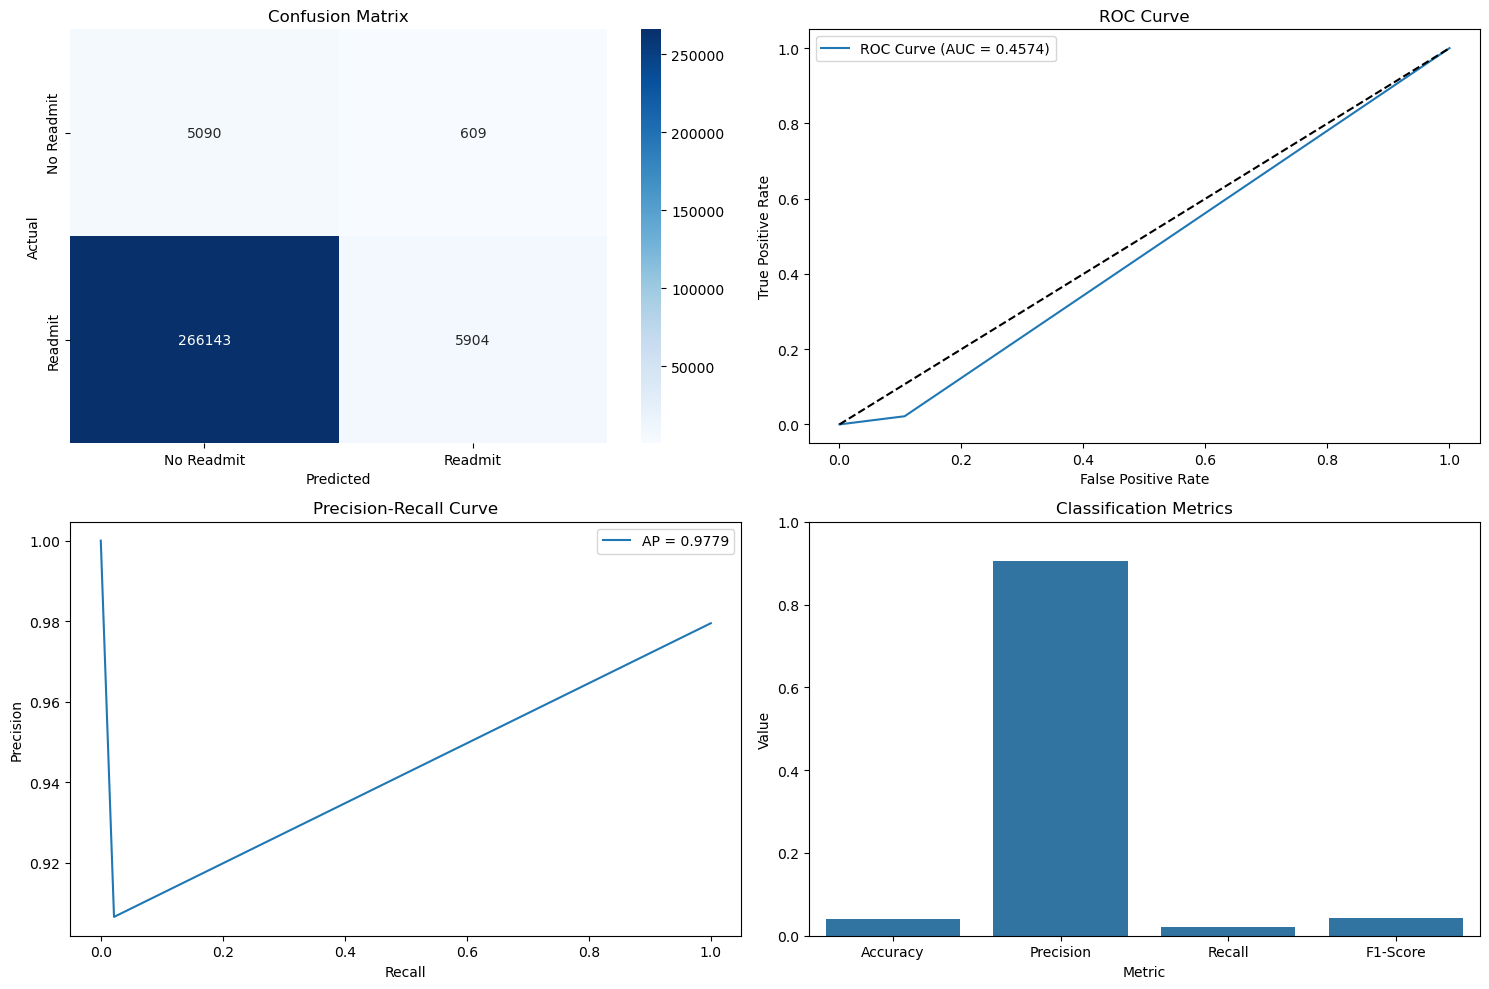

In [43]:
# Calculate basic metrics
master_df['lace_readmit'] = pd.to_numeric(master_df['lace_readmit'], errors='coerce')
master_df['actual_readmit'] = pd.to_numeric(master_df['actual_readmit'], errors='coerce')

accuracy = accuracy_score(master_df['actual_readmit'], master_df['lace_readmit'])
conf_matrix = confusion_matrix(master_df['actual_readmit'], master_df['lace_readmit'])
report = classification_report(master_df['actual_readmit'], master_df['lace_readmit'], output_dict=True)

# Calculate ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(master_df['actual_readmit'], master_df['lace_readmit'])
roc_auc = roc_auc_score(master_df['actual_readmit'], master_df['lace_readmit'])

# Calculate precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(master_df['actual_readmit'], master_df['lace_readmit'])
avg_precision = average_precision_score(master_df['actual_readmit'], master_df['lace_readmit'])

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print("\nClassification Report:")
print(classification_report(master_df['actual_readmit'], master_df['lace_readmit']))

# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Confusion Matrix
plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Readmit', 'Readmit'],
            yticklabels=['No Readmit', 'Readmit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# 2. ROC Curve
plt.subplot(2, 2, 2)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random prediction line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# 3. Precision-Recall Curve
plt.subplot(2, 2, 3)
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# 4. Classification Metrics Bar Chart
plt.subplot(2, 2, 4)
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy, report['1']['precision'], report['1']['recall'], report['1']['f1-score']]
})
sns.barplot(x='Metric', y='Value', data=metrics)
plt.ylim(0, 1)
plt.title('Classification Metrics')

plt.tight_layout()
plt.show()



In [56]:
# INTERPRET LACE SCORE - lower threshhold

master_df["lace_readmit"] = master_df["LACE_score"].apply(lambda x: "1" if x > 5 else 0)
master_df["actual_readmit"] = master_df["length_of_stay"].apply(lambda x: "1" if x <= 30 else 0)

master_df.to_csv("../../processed_data/master_df.csv")

Accuracy: 0.3675
ROC AUC: 0.1876
Average Precision: 0.9673

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5699
           1       0.95      0.38      0.54    272047

    accuracy                           0.37    277746
   macro avg       0.47      0.19      0.27    277746
weighted avg       0.93      0.37      0.53    277746



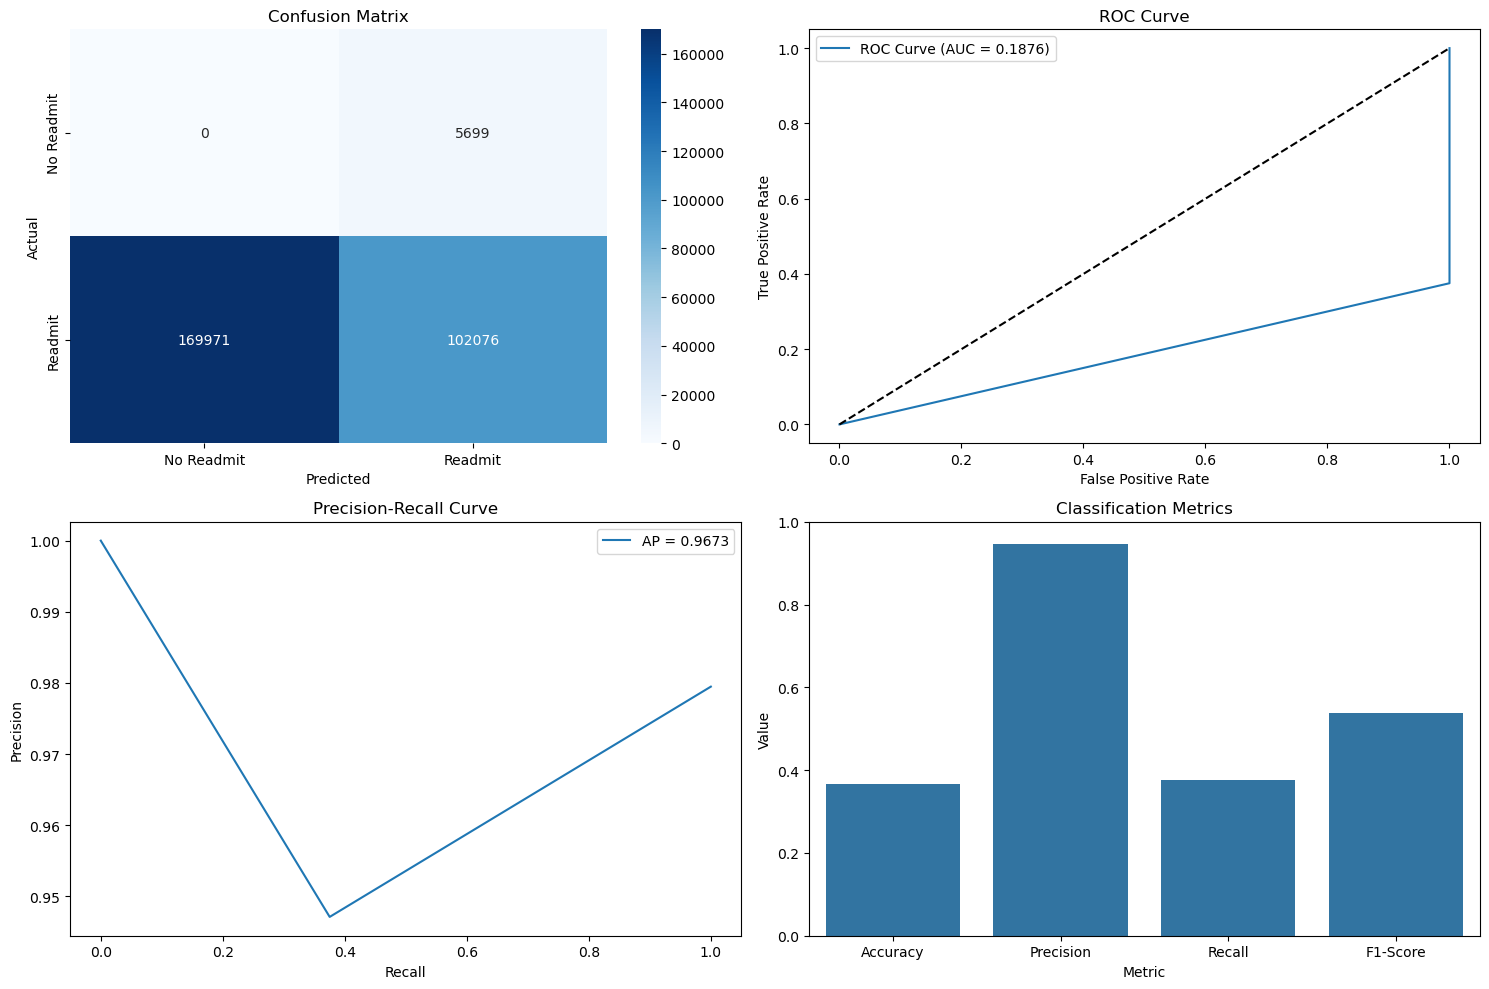

In [57]:
# Calculate basic metrics
master_df['lace_readmit'] = pd.to_numeric(master_df['lace_readmit'], errors='coerce')
master_df['actual_readmit'] = pd.to_numeric(master_df['actual_readmit'], errors='coerce')

accuracy = accuracy_score(master_df['actual_readmit'], master_df['lace_readmit'])
conf_matrix = confusion_matrix(master_df['actual_readmit'], master_df['lace_readmit'])
report = classification_report(master_df['actual_readmit'], master_df['lace_readmit'], output_dict=True)

# Calculate ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(master_df['actual_readmit'], master_df['lace_readmit'])
roc_auc = roc_auc_score(master_df['actual_readmit'], master_df['lace_readmit'])

# Calculate precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(master_df['actual_readmit'], master_df['lace_readmit'])
avg_precision = average_precision_score(master_df['actual_readmit'], master_df['lace_readmit'])

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print("\nClassification Report:")
print(classification_report(master_df['actual_readmit'], master_df['lace_readmit']))

# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Confusion Matrix
plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Readmit', 'Readmit'],
            yticklabels=['No Readmit', 'Readmit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# 2. ROC Curve
plt.subplot(2, 2, 2)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random prediction line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# 3. Precision-Recall Curve
plt.subplot(2, 2, 3)
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# 4. Classification Metrics Bar Chart
plt.subplot(2, 2, 4)
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy, report['1']['precision'], report['1']['recall'], report['1']['f1-score']]
})
sns.barplot(x='Metric', y='Value', data=metrics)
plt.ylim(0, 1)
plt.title('Classification Metrics')

plt.tight_layout()
plt.show()

